# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [2]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN


## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [486]:
# Зачем передаем в Clustering параметры из sklearn ?????
from sklearn.base import BaseEstimator, ClusterMixin
class Clustering(BaseEstimator, ClusterMixin):
    """
    Clustering algorithm
    """

    def __init__(self, epsilon=0.5, min_pts=2):
        """
        Algorithm parameters:
        epsilon
        min_pts
        """
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.noise = []
        self.clusters = {}
        self.clustered = []
        return

    def neighbours(self, obj, X, kind='simple'):

        if kind == 'simple':
            return [obj_1.tolist() for obj_1 in X if np.linalg.norm(np.array(obj) - obj_1) < self.epsilon]


    def expand_cluster(self, obj, C, nbrs, NV, x):

        self.clusters[C].append(obj)
        self.clustered.append(obj)
        for nbr in nbrs:
            if nbr in NV:  # object not visited
                NV.remove(nbr)  # mark as visited
                nbr_nbrs = self.neighbours(nbr, x)
                if len(nbr_nbrs) >= self.min_pts:
                    for each in nbr_nbrs:
                        if each not in nbrs:
                            nbrs.append(each) # join sets of neighbours
                if nbr not in self.clustered:
                    self.clusters[C].append(nbr)
                    self.clustered.append(nbr)
                if nbr in self.noise:
                    ind = (self.noise == nbr).all(axis=1).nonzero()
                    np.delete(self.noise, ind, 0)

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        C = 0
        NV = x.tolist()  # not visited objects
        while len(NV) !=0:
            for obj in NV:
                NV.remove(obj)  # mark as visited
                nbrs = self.neighbours(obj, x)  # list of neighbours
                if len(nbrs) < self.min_pts:
                    self.noise.append(obj)  # mark as noise
                else:
                    self.clusters[C] = []
                    self.expand_cluster(obj, C, nbrs, NV, x)
                    C += 1

        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        clusters_vec = []
        for p in x:
            if p.tolist() in self.noise:
                clusters_vec.append(-1) # mark noise as -1
            else:
                [clusters_vec.append(num) for num, points in self.clusters.items() if p.tolist() in points]

        return clusters_vec

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

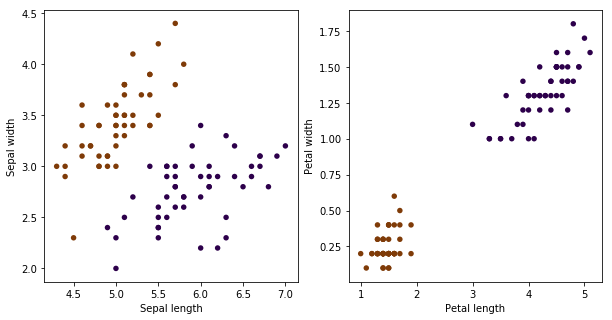

In [487]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Sepal length')
pl.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Petal length')
pl.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [490]:
pred_iris = Clustering(epsilon=.5, min_pts=3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.87


In [489]:
pred_iris = Clustering(epsilon=0.65, min_pts=3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

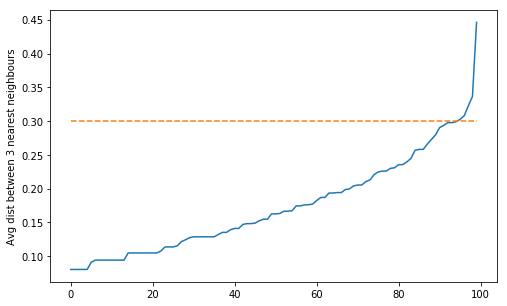

In [447]:
def params(X, y=None, minpts=3):
    avgs = []
    for x in X:
        nbrs = [np.linalg.norm(x - point) for point in X]
        avg=np.sum(np.sort(np.array(nbrs))[:minpts])/minpts
        avgs.append(avg)
    
    return np.sort(np.array(avgs))

pl.figure(figsize=(8, 5))
pl.plot(params(x))
pl.plot(np.ones(100)*0.3,'--')
pl.ylabel("Avg dist between 3 nearest neighbours")
pl.show()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

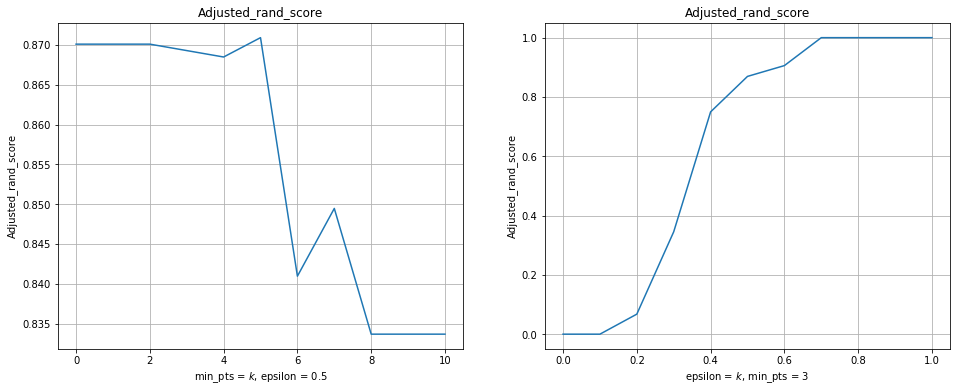

In [503]:
ks = range(11)
criteria = np.zeros(len(ks))
criteria_eps = np.zeros(len(ks))
x = x_iris

for i in ks:
    cls = Clustering(epsilon = 0.5, min_pts = i) 
    y = cls.fit_predict(x)
    criteria[i] = smt.adjusted_rand_score(y_iris, y)

    cls_eps = Clustering(epsilon = i/10, min_pts = 3)  
    y_eps = cls_eps.fit_predict(x)
    criteria_eps[i] = smt.adjusted_rand_score(y_iris, y_eps)
    

fig, [ax1, ax2] = pl.subplots(1, 2, figsize=(16, 6))

ax1.plot(ks, criteria)
ax1.set_title("Adjusted_rand_score")
ax1.set_ylabel("Adjusted_rand_score")
ax1.set_xlabel("min_pts = $k$, epsilon = 0.5")
ax1.grid()

ax2.plot(np.array(ks)/10, criteria_eps)
ax2.set_title("Adjusted_rand_score")
ax2.set_ylabel("Adjusted_rand_score")
ax2.set_xlabel("epsilon = $k$, min_pts = 3")
ax2.grid()

pl.show()

Оптимальное сочетание параметров: epsilon = 0.65, min_pts = 3

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

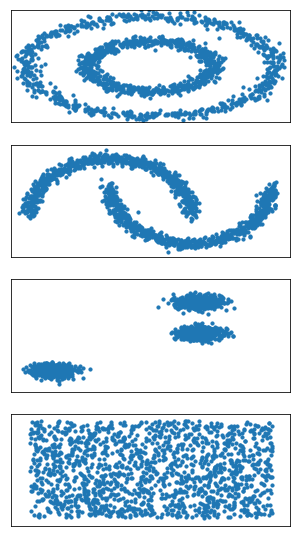

In [3]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

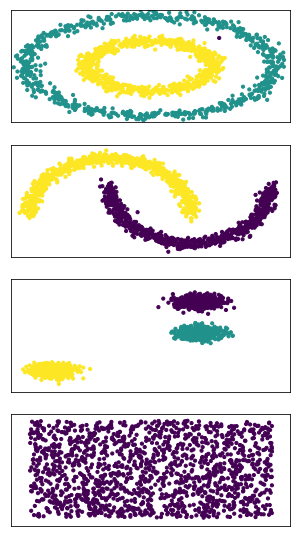

In [521]:
plt.figure(figsize=(2 + 3, 9.5))
plt.title('My DBSCAN')

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    cls = Clustering(epsilon=0.25, min_pts=3)
    y_pred = cls.fit_predict(X)
    
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

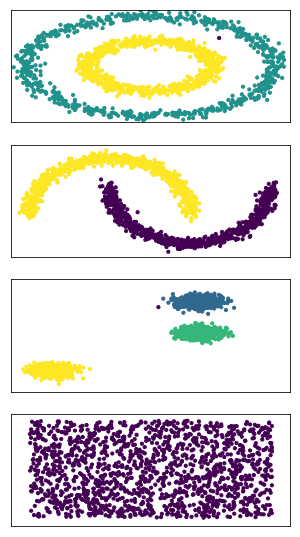

In [4]:
from sklearn import cluster

plt.figure(figsize=(2 + 3, 9.5))
plt.title('Sklearn DBSCAN')

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    dbscan = cluster.DBSCAN(eps=0.2)
    dbscan_pred = dbscan.fit_predict(X)
    
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=dbscan_pred)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.